<a href="https://colab.research.google.com/github/ucheokechukwu/ml_tensorflow_deeplearning/blob/main/09_skimlit_nlp_milestone_project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 2 SkimLit

The purpose of this model is to build an NLP to make reading medical abstracts easier.
Ref the original paper: https://arxiv.org/pdf/1710.06071.pdf

The model architecture is described here: https://arxiv.org/pdf/1612.05251.pdf


In [1]:
!nvidia-smi

Sun Mar 12 11:32:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    27W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# get helper function
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import calculate_results


--2023-03-12 11:32:36--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-12 11:32:36 (85.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get data
Since we'll be replicating the paper above, let's download the dataset theyused. We can do so from the author's github
https://github.com/Franck-Dernoncourt/pubmed-rct

In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 6.75 MiB/s, done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [4]:
# check what files we're doing in the pubmed-20K dataset
!ls /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


* note that dev is another name for validation_set
* we need a preprocessing function to read the text files and turn them into data and labels

In [5]:
# start our experiments using the 20K datasetwith numbers replaced by @ sign

data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
import os

filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## preprocess data

one of the best ways to become one with the data is to VISUALIZE VISUALIZE VISUALZE

* create a function to read in all the lines to a target text file

In [6]:
# Create a function to read the lines of a document
def get_lines(filename):
  """
  reads filename (a text filename) and returns the lines of text as a list

  Args:
    filename: a string containing the target filepath
  Returns: 
  a list of strings with noe string per line  from the target filename
  """

  with open (filename, "r") as f:
    return f.readlines()

In [7]:
# let's test this out

train_lines = get_lines(data_dir+"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040

* let's think about how we want our data to look...
* how I think our data would be best represented...

```
[{'line_number': 0,
'target': 'BACKGROUND',
'text': "Emotional eating is associated with overeating and the development of obesity .\n"
'total_lines': 11},
...
]
```


* Let's write a function that changes text to line numbers

In [9]:
def preprocess_text_with_line_numbers(filename):
  """
  returns a list of dictionaries of abstract line data.
  takes in filenames, reads its contents and sorts through each line
  extracting things like target label, the text of the sentence, 
  how many sentences are in the current abstract
  and waht sentence number the target line is.
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts, we're returning a list of dictionaries, remember?
  
  # loop through each line in the target file
  for line in input_lines:
    if  line.startswith("###"): # check to see if this is an id line. this tells us that a new abstract is starting
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the line is an ID line
    elif line.isspace(): #checking to see if this is a newline character
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # iterate through each line in a single abstract and acoun tthem at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # splits target label from text
        # 'BACKGROUND\tEmotional eating is associated with overeating and the development of obesity .\n' -> split at /t
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number does this line appear in the abstract
        line_data["total_lines"] = len(abstract_line_split) - 1 # so that this starts from zero
        abstract_samples.append(line_data) # add line data dictionary to the abstract samples list
      
    else: # if the above conditions are not fulfilled, the line contains a labelled sentence...
        abstract_lines +=line
  return abstract_samples
 

In [10]:
# get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")


CPU times: user 656 ms, sys: 105 ms, total: 762 ms
Wall time: 2.24 s


In [11]:
len(test_samples), len(train_samples), len(val_samples)

(30135, 180040, 30212)

In [12]:
val_samples[32]

{'target': 'BACKGROUND',
 'text': 'patient adherence to appointments is key to improving outcomes in health care .',
 'line_number': 0,
 'total_lines': 9}

Now that our data is in the format of a list of dictionaries, how about we turn it into a DataFrame to further visualize it...

In [13]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(25)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [14]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<AxesSubplot:ylabel='Frequency'>

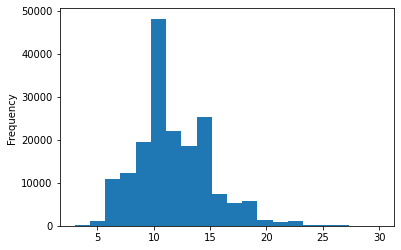

In [15]:
# let's check the length of different lines
train_df.total_lines.plot.hist(bins=20)

### get lists of sentences

In [16]:
# convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [17]:
# view the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [18]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


## making numeric labels (ML models require numeric labels)

In [19]:
# we're going to both label and one-hot encode the labels (target)
train_df["target"]

0           OBJECTIVE
1             METHODS
2             METHODS
3             METHODS
4             METHODS
             ...     
180035        RESULTS
180036        RESULTS
180037        RESULTS
180038    CONCLUSIONS
180039    CONCLUSIONS
Name: target, Length: 180040, dtype: object

In [20]:
# one hot encoding
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [21]:
import tensorflow as tf
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

In [22]:
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

## label encode labels


In [23]:
# extract lanbels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

In [24]:
len(train_labels_encoded)

180040

In [25]:
# get class names for the labels i.e. map the numeric versions of the labels into text

num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling experiments
As usual, we're going to try out a bunch of different models and see which one works best.
As usual, we'll start with a baseline TFIDF multimonial Naive Bayes classifier.

# Model 0: Baseline model

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [27]:
# Create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB()),
])

# fit the pipeline to the training data
model_0.fit(X=train_sentences, y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [28]:
# evaluate baseline model on validation dataset
model_0.score(X=val_sentences, y=val_labels_encoded)

0.7218323844829869

In [29]:
# make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [30]:
baseline_results = calculate_results(y_true = val_labels_encoded, y_pred = baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

# Preparing our data (the text) for deep sequence models

before we start building deeper models, we've got to create vectorization and embedding layers

In [31]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [32]:
# how long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_lens = np.mean(sent_lens)
avg_sent_lens

26.338269273494777

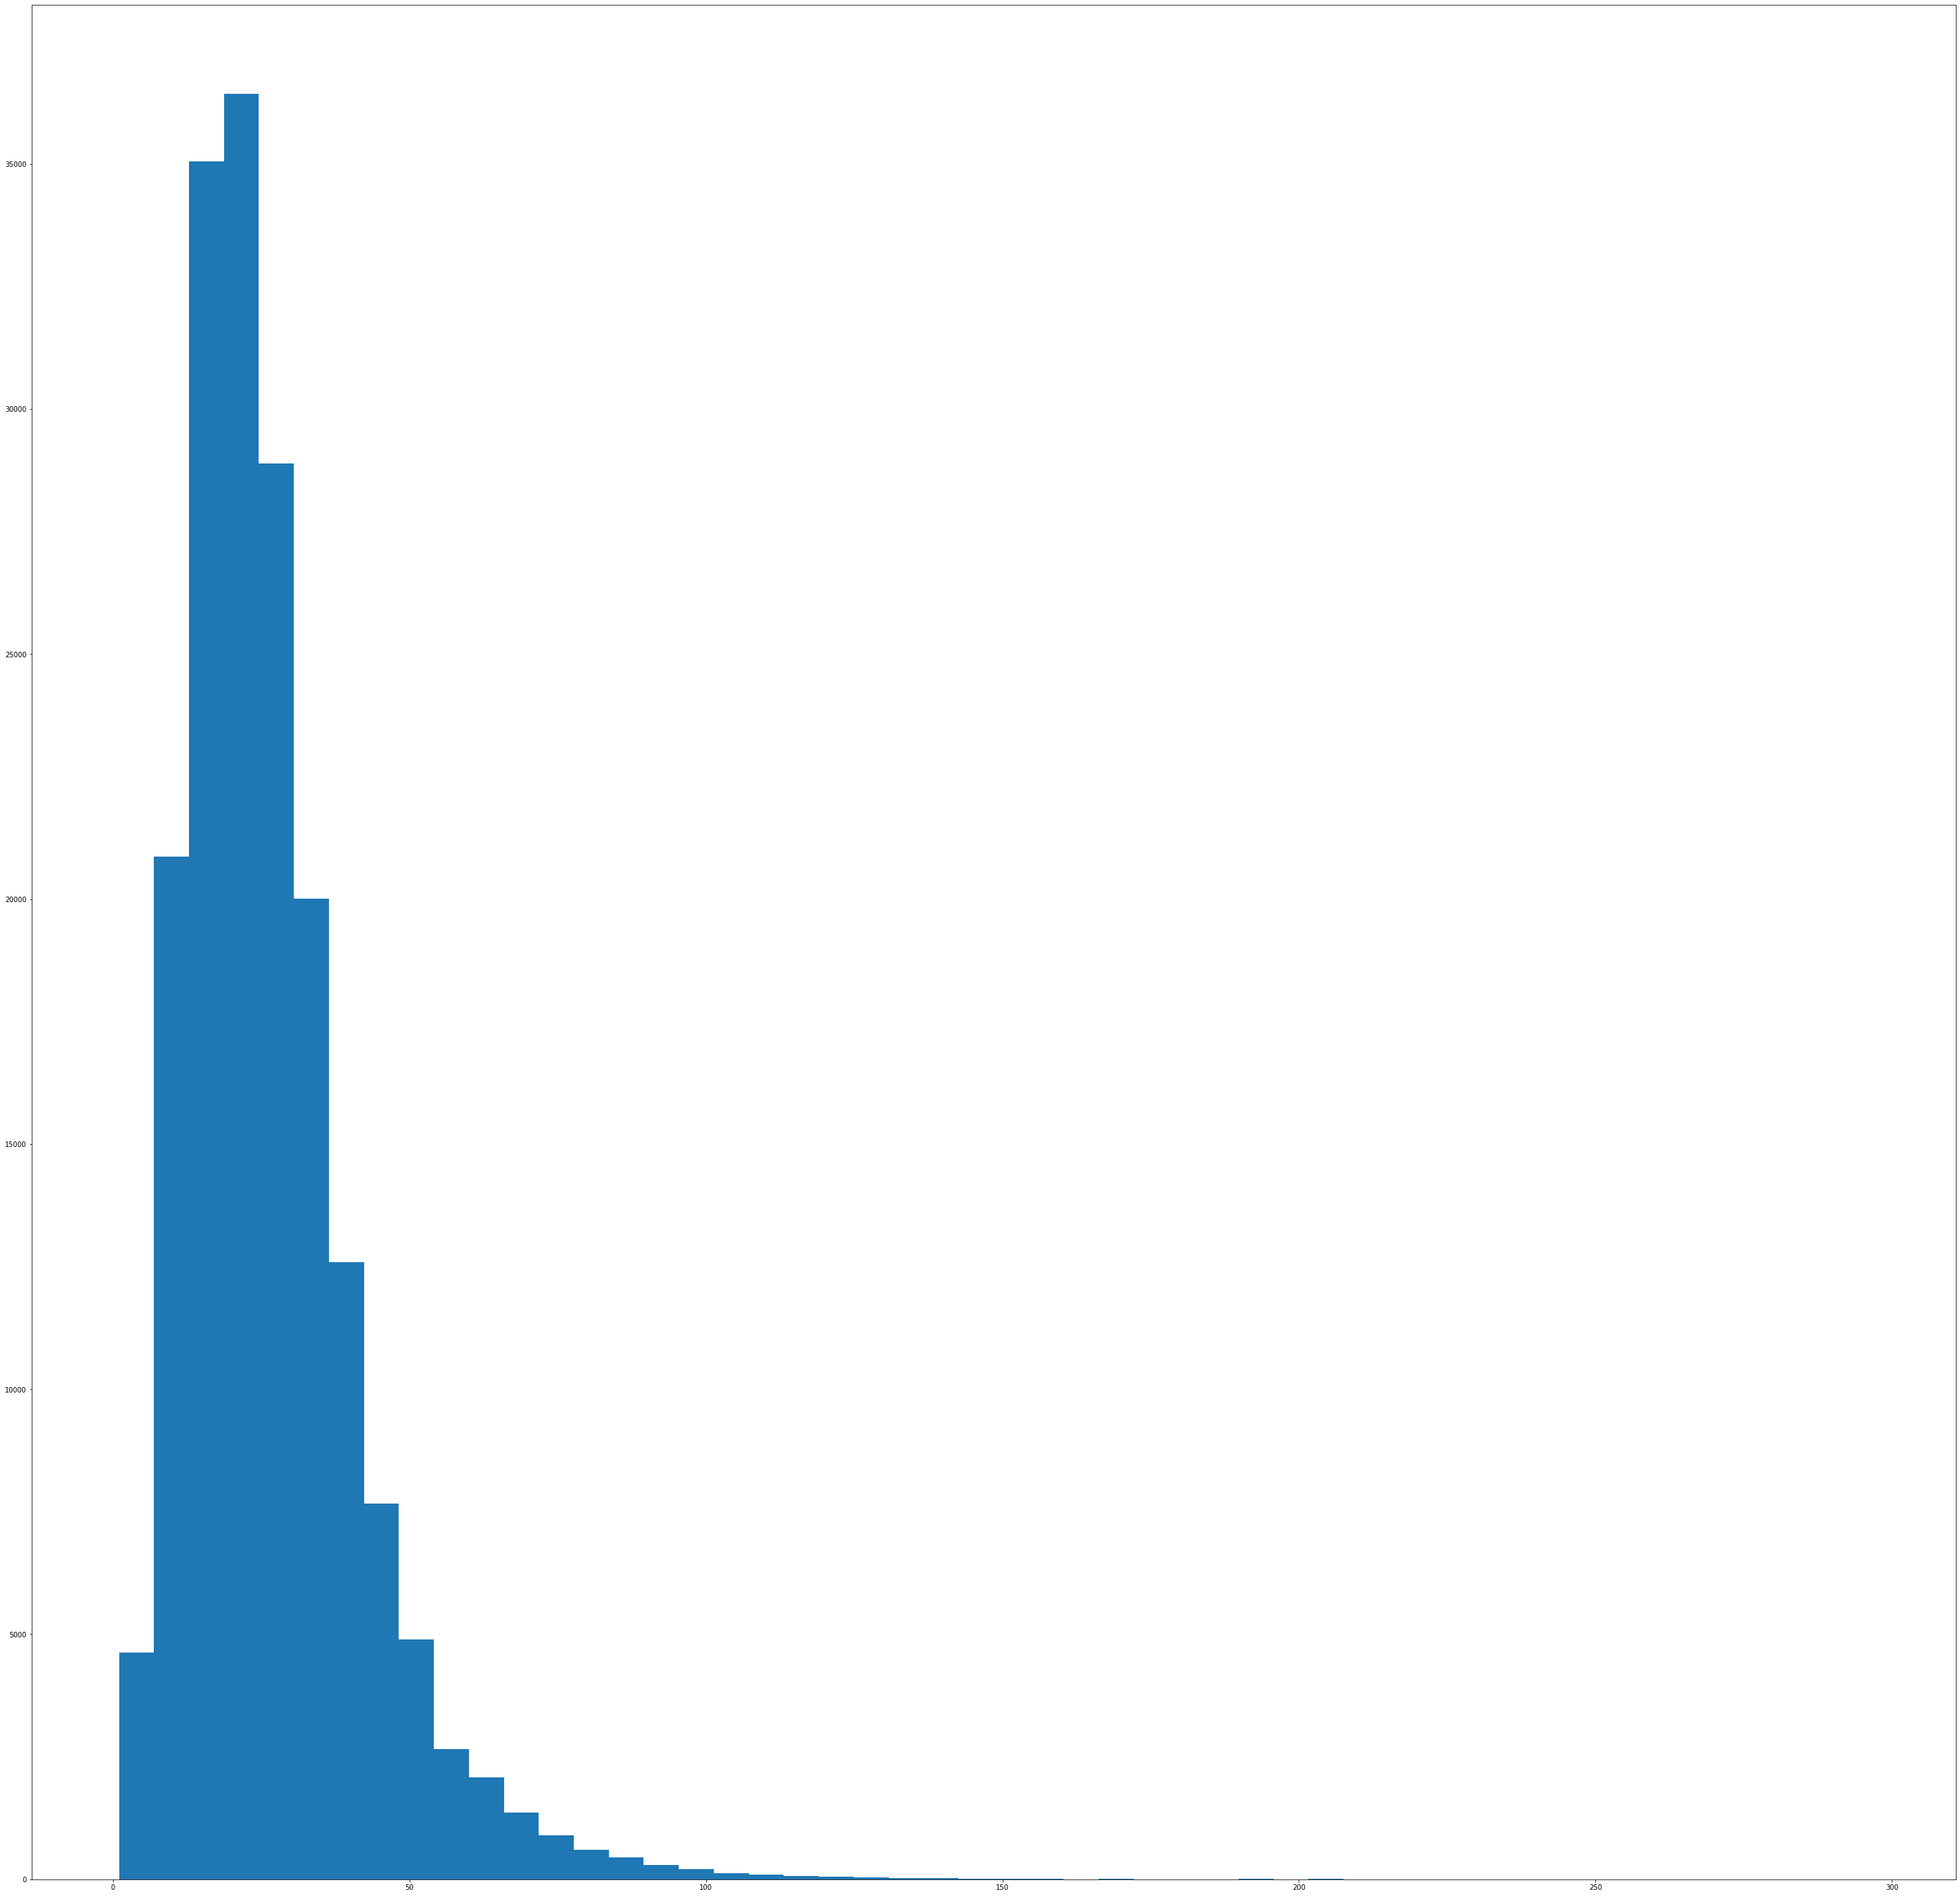

In [33]:
# what's the distribution look like?
import matplotlib.pyplot as plt
plt.figure(figsize=(50,50))
plt.hist(sent_lens, bins=50);

In [34]:
# how long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [35]:
max(sent_lens)

296

### create text vectorizer layer

we want to make a layer w hich maps our text from words into numbers

* the number of word sin our vocab is taken from table 2 in the papaer


In [36]:
max_tokens = 68000 # taken from the paper

# Create text vectorizer
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=55) # desired output length of vectorized sequences

In [37]:
# add text vectorizer to training sentences...
text_vectorizer.adapt(train_sentences)

In [38]:
# how many words in our training vocabulary

rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [39]:
# get teh config of our text vectorizer

text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8'}

* technically we can build a model from this... but creating an embedding layer is better

In [40]:
from tensorflow.keras.layers import Embedding

token_embed = Embedding(input_dim=len(rct_20k_text_vocab),
                        output_dim=128,
                        mask_zero=True, # helps tensorflow do more efficient computing where there are a lot of zeros
                        name = "token_embedding")

In [41]:
# test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n {target_sentence}")
print(f"\nLength of text: {len(target_sentence)}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
 nct@ .

Length of text: 6

Vectorized text: [[176   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]]


In [42]:
# test with embedding example...
print(f"setnence before vectorization:\n {target_sentence}")
vectorized_sentence = text_vectorizer([target_sentence])

print(f"sentence after vectorization:\n {vectorized_sentence}")
print(vectorized_sentence.shape)
embedded_sentence = token_embed(vectorized_sentence)
print(f"sentence after embedding:\n {embedded_sentence}")
print(f"Embedded shape: {embedded_sentence.shape}")

setnence before vectorization:
 nct@ .
sentence after vectorization:
 [[176   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]]
(1, 55)
sentence after embedding:
 [[[ 0.02322713  0.01682464 -0.02059898 ...  0.00695943 -0.04914738
    0.02666701]
  [-0.00624887 -0.02265589 -0.00943725 ...  0.04209951 -0.00750808
    0.01979729]
  [-0.00624887 -0.02265589 -0.00943725 ...  0.04209951 -0.00750808
    0.01979729]
  ...
  [-0.00624887 -0.02265589 -0.00943725 ...  0.04209951 -0.00750808
    0.01979729]
  [-0.00624887 -0.02265589 -0.00943725 ...  0.04209951 -0.00750808
    0.01979729]
  [-0.00624887 -0.02265589 -0.00943725 ...  0.04209951 -0.00750808
    0.01979729]]]
Embedded shape: (1, 55, 128)


## Creating datasets
https://www.tensorflow.org/guide/data_performance

https://www.tensorflow.org/guide/data

* we're going to set up our data to run as fast as possible with the TensorFlow tf.data API. 

In [43]:
# Turn our data into TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [44]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [45]:
# take the TensorSliceDataset and turn them into PreFetch and Batch dataset - to make datasets more efficient to load into models
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [46]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

# Model 1: Conv1D with token embeddings

In [47]:
# create 1D conv model to preocess sequencess
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(84, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss="categorical_crossentropy",
              optimizer="Adam",
              metrics="accuracy")

model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 84)            53844     
                                                                 
 global_average_pooling1d (G  (None, 84)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 425   

In [48]:
# fit the model
history_model_1 = model_1.fit(train_dataset, 
                              steps_per_epoch = int(0.1* len(train_dataset)),
                              epochs=3,
                              validation_data = valid_dataset,
                              validation_steps = int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 53s 66ms/step - loss: 0.9095 - accuracy: 0.6410 - val_loss: 0.6806 - val_accuracy: 0.7420
Epoch 2/3
562/562 [==============================] - 7s 12ms/step - loss: 0.6513 - accuracy: 0.7596 - val_loss: 0.6276 - val_accuracy: 0.7693
Epoch 3/3
562/562 [==============================] - 6s 11ms/step - loss: 0.6129 - accuracy: 0.7767 - val_loss: 0.5948 - val_accuracy: 0.7812


In [49]:
# evaluate on whole dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 5s 6ms/step - loss: 0.5955 - accuracy: 0.7861


[0.5954568982124329, 0.7860783934593201]

In [50]:
# make predictions with our models
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs.shape

945/945 [==============================] - 2s 3ms/step


(30212, 5)

In [51]:
model_1_pred_probs[:5]

array([[4.62998927e-01, 1.26958951e-01, 7.63253793e-02, 3.17651391e-01,
        1.60653926e-02],
       [4.39937919e-01, 2.70960271e-01, 1.57831311e-02, 2.63278693e-01,
        1.00400029e-02],
       [1.20500915e-01, 4.57066949e-03, 1.02876406e-03, 8.73883903e-01,
        1.58243438e-05],
       [1.75774057e-05, 6.24098582e-04, 9.78876591e-01, 1.10811006e-05,
        2.04706285e-02],
       [1.66301080e-03, 5.32044470e-02, 3.64915729e-01, 9.70637309e-04,
        5.79246163e-01]], dtype=float32)

In [52]:
# convert prediction probabilities to classses
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 0, 3, 2, 4])>

In [53]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [54]:
model_1_predictions = class_names[model_1_preds]
len(model_1_predictions)
model_1_predictions[:10]

array(['BACKGROUND', 'BACKGROUND', 'OBJECTIVE', 'METHODS', 'RESULTS',
       'METHODS', 'RESULTS', 'METHODS', 'RESULTS', 'CONCLUSIONS'],
      dtype=object)

In [55]:
model_1_results = calculate_results(y_true = val_labels_encoded, y_pred = model_1_preds)
model_1_results

{'accuracy': 78.60783794518734,
 'precision': 0.7832624553299887,
 'recall': 0.7860783794518734,
 'f1': 0.7837418685641381}

In [56]:
tf

<module 'tensorflow' from '/usr/local/lib/python3.9/dist-packages/tensorflow/__init__.py'>

In [57]:
import tensorflow as tf

# model 2: feature extraction with pretrained token embeddings

now let's use pretrained word embeddings from Tensorflow Hub, specifically the universal sentence encoder...

https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder

* The input is variable length English text and the output is a 512 long vector

In [58]:
# download pretrained TensorflowHub USE
import tensorflow_hub as hub

tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [59]:
# test out the pretrained embedding  on a random sentence...
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding: \n {use_embedded_sentence[0][:30]}")
print(f"lenght of the sentence embedding: \n {len(use_embedded_sentence[0])}")

Random sentence:
 nourish families significantly improved on child bmi from pre - to post-testing after adjustment for random effects , baseline bmi , and child race .
Sentence after embedding: 
 [-0.06236803 -0.00156071 -0.0086196  -0.03401303 -0.07977618 -0.06442782
 -0.01758364  0.01449195  0.0622879   0.01320964  0.05441762 -0.01238109
  0.03977986 -0.06703269 -0.07455493  0.02124547 -0.08193841  0.03037206
 -0.07830591 -0.05324484 -0.01660554  0.06667454  0.0072609  -0.00246663
  0.0240091   0.02998734 -0.03136344  0.04208155 -0.04736515  0.01959843]
lenght of the sentence embedding: 
 512


In [60]:
inputs = layers.Input(shape=[], dtype = "string", name="input_layer")
x = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(x) # you could add more layers here if you want to
outputs = layers.Dense(num_classes, activation = "softmax")(x)
model_2 = tf.keras.Model(inputs, outputs, name = "model_2_USE_feature_extractor")


model_2.compile(loss="categorical_crossentropy", optimizer="Adam", metrics="accuracy")
model_2.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [61]:
# fit model to data
history_2 = model_2.fit(train_dataset,
                        epochs=3,
                        steps_per_epoch = int(0.1*len(train_dataset)),
                        validation_data = valid_dataset,
                        validation_steps = int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 14s 19ms/step - loss: 0.9151 - accuracy: 0.6511 - val_loss: 0.7978 - val_accuracy: 0.6905
Epoch 2/3
562/562 [==============================] - 11s 19ms/step - loss: 0.7695 - accuracy: 0.7021 - val_loss: 0.7549 - val_accuracy: 0.7015
Epoch 3/3
562/562 [==============================] - 11s 20ms/step - loss: 0.7527 - accuracy: 0.7113 - val_loss: 0.7401 - val_accuracy: 0.7114


In [62]:
# evaluate on the validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 14s 15ms/step - loss: 0.7423 - accuracy: 0.7122


[0.7423052787780762, 0.7122335433959961]

In [63]:
# make predictions
model_2_pred_probabilities = model_2.predict(valid_dataset)
model_2_predictions = tf.argmax(model_2_pred_probabilities, axis=1)

945/945 [==============================] - 17s 16ms/step


In [64]:
model_2_predictions

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [153]:
model_2_results = calculate_results(y_true = val_labels_encoded, y_pred = model_2_predictions)
model_2_results

{'accuracy': 71.22335495829472,
 'precision': 0.7127605227235139,
 'recall': 0.7122335495829472,
 'f1': 0.7091098040821843}

In [66]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

# Model 3 Conv1D with character embeddings

The paper which we're replicating states they used a combination of token and character-level embeddings.
Previously we've used token level embeddings but we'll need to do similar steps for characters.

In [67]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [68]:
# make function to split sentences into characters

In [69]:
def split_chars(text):
  return " ".join(list(text))

In [70]:
# text splitting non-character-level sequence into characters
split_chars(random_train_sentence)

'n o u r i s h   f a m i l i e s   s i g n i f i c a n t l y   i m p r o v e d   o n   c h i l d   b m i   f r o m   p r e   -   t o   p o s t - t e s t i n g   a f t e r   a d j u s t m e n t   f o r   r a n d o m   e f f e c t s   ,   b a s e l i n e   b m i   ,   a n d   c h i l d   r a c e   .'

In [71]:
# split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]

val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]


In [72]:
len(train_chars), len(train_sentences)

(180040, 180040)

In [73]:
# what's the average character length?
chars_len = [len(sentence) for sentence in train_sentences]
mean_chars_len = np.mean(chars_len)
mean_chars_len

149.3662574983337

(array([4.3065e+04, 8.9738e+04, 3.6231e+04, 8.4400e+03, 1.8710e+03,
        4.6700e+02, 1.3900e+02, 4.5000e+01, 2.5000e+01, 1.1000e+01,
        3.0000e+00, 2.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.00000000e+00, 9.33333333e+01, 1.85666667e+02, 2.78000000e+02,
        3.70333333e+02, 4.62666667e+02, 5.55000000e+02, 6.47333333e+02,
        7.39666667e+02, 8.32000000e+02, 9.24333333e+02, 1.01666667e+03,
        1.10900000e+03, 1.20133333e+03, 1.29366667e+03, 1.38600000e+03]),
 <BarContainer object of 15 artists>)

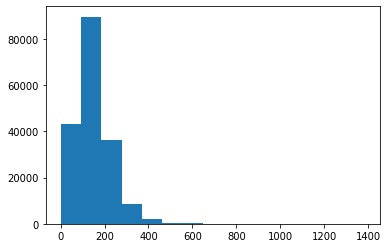

In [74]:
# check the distribution of our sequences at a character level
import matplotlib.pyplot as plt
plt.hist(chars_len, bins=15)

In [75]:
# find what character lenght covers 95% of sequences
output_seq_chars_len = int(np.percentile(chars_len, 95))
output_seq_chars_len

290

In [76]:
# get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet, len(alphabet)

('abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~', 68)

In [77]:
# create char level token vectorizer instance
# NUM_CHAR_TOKENS = len(alphabet) + 2 # for space and OOV token

NUM_CHAR_TOKENS = 28

char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                    output_sequence_length = output_seq_chars_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

In [78]:
# adapt vectorizer to training character
char_vectorizer.adapt(train_chars)

In [79]:

# check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}.")

print(f"5 most common characters: \n{char_vocab[:5]}")
print(f"5 least common characters: \n{char_vocab[-5:]}")

Number of different characters in character vocab: 28.
5 most common characters: 
['', '[UNK]', 'e', 't', 'i']
5 least common characters: 
['k', 'x', 'z', 'q', 'j']


In [82]:
# test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"Length of random_train_chars: {len(random_train_chars)}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\Vectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 t h r e e   s e s s i o n s   o f   t r e a t m e n t   w e r e   r e q u i r e d   .
Length of random_train_chars: 85
\Vectorized chars:
 [[ 3 13  8  2  2  9  2  9  9  4  7  6  9  7 17  3  8  2  5  3 15  2  6  3
  20  2  8  2  8  2 26 16  4  8  2 10  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  

### creating the character level embedding

In [83]:
char_embed = layers.Embedding(input_dim = len(char_vocab), 
                              output_dim=25, # this is the size of the char embedding in the paper 
                              mask_zero=True,
                              name="char_embed")

In [87]:
# test our character embedding layer
print(f"Charified text: \n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n {char_embed_example}\n")
print(f"Char embedding shape: {char_embed_example.shape}")

Charified text: 
t h r e e   s e s s i o n s   o f   t r e a t m e n t   w e r e   r e q u i r e d   .

Embedded chars (after vectorization and embedding):
 [[[ 2.66864151e-03  4.52976115e-02 -2.91724931e-02 ... -1.19654760e-02
   -9.27820802e-05  1.65174641e-02]
  [ 8.72649997e-03  2.11366452e-02  4.20437492e-02 ...  2.38387845e-02
    2.25807168e-02  4.10303473e-05]
  [ 3.33270468e-02  1.83175467e-02 -5.35118580e-03 ... -1.28462911e-02
   -2.60606296e-02 -4.07795310e-02]
  ...
  [ 1.25693195e-02  3.89369614e-02  2.94023193e-02 ...  1.37922205e-02
   -3.04194335e-02 -2.99986135e-02]
  [ 1.25693195e-02  3.89369614e-02  2.94023193e-02 ...  1.37922205e-02
   -3.04194335e-02 -2.99986135e-02]
  [ 1.25693195e-02  3.89369614e-02  2.94023193e-02 ...  1.37922205e-02
   -3.04194335e-02 -2.99986135e-02]]]

Char embedding shape: (1, 290, 25)


### Building a Conv1D model to fit on character embeddings

In [100]:
# Make Conv1D on chars only 
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same")(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_conv1D_character_embedding")

model_3.compile(loss="categorical_crossentropy",
                optimizer = "Adam",
                metrics=["accuracy"])

model_3.summary()


Model: "model_3_conv1D_character_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_4 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_4 (Dense)             (No

## optimizing the dataset for character embedding

In [97]:
# create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [93]:
train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [101]:
model_3_history = model_3.fit(train_char_dataset,
                              epochs=3,
                              steps_per_epoch = int(0.1* len(train_char_dataset)),
                              validation_data = val_char_dataset,
                              validation_steps = int(0.1* len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 5s 7ms/step - loss: 1.2852 - accuracy: 0.4647 - val_loss: 1.1674 - val_accuracy: 0.5156
Epoch 2/3
562/562 [==============================] - 3s 6ms/step - loss: 1.1329 - accuracy: 0.5340 - val_loss: 1.0662 - val_accuracy: 0.5715
Epoch 3/3
562/562 [==============================] - 4s 7ms/step - loss: 1.0347 - accuracy: 0.5864 - val_loss: 0.9726 - val_accuracy: 0.6257


In [104]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.9976 - accuracy: 0.6118


[0.9975578784942627, 0.6117767691612244]

* the evaluate result with `AveragePooling` was 0.4044

In [103]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 4s 4ms/step


array([[0.10051206, 0.5589003 , 0.14985684, 0.11704865, 0.0736822 ],
       [0.12406491, 0.4147602 , 0.02306966, 0.36698085, 0.07112435],
       [0.11138938, 0.15686478, 0.31565318, 0.33045447, 0.08563827],
       ...,
       [0.06800663, 0.08705945, 0.04740972, 0.0434216 , 0.7541026 ],
       [0.02959814, 0.0829547 , 0.5893204 , 0.0553178 , 0.24280895],
       [0.16422705, 0.6724653 , 0.10859699, 0.04426009, 0.01045051]],
      dtype=float32)

In [106]:
model_3_predictions = tf.argmax(model_3_pred_probs, axis=1)
model_3_predictions[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([1, 1, 3, 2, 2])>

In [110]:
# Calculate the results
model_3_results = calculate_results(y_true = val_labels_encoded, y_pred = model_3_predictions)
model_3_results

{'accuracy': 61.1776777439428,
 'precision': 0.6161692537278769,
 'recall': 0.611776777439428,
 'f1': 0.595539730603514}

In [111]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

* This is our worst results so far.


# Model 4 - Combining a pretrained token embeddings + character embeddings (hybrid)
1. create a token-level embedding (similar to `model_1`)
2. create a character-level embedding (similar to `model_3` with a slight modification)
3. combine 1 & 2 with a concantenate (`layers.Concatenate`)
4. build a series of output layers on top of 3 similar to Fig1  and section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
5. Construct a model which takes token and character-level sequences as input and produces sequence level probabilities as output. 

- **Drop out** means removing randomly removing some of the weights from the patterns.

In [129]:
# 1. set up the token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings) # the paper used 300
token_model = tf.keras.Model(token_inputs, token_output, name="token_model")



In [130]:
# 2. set up character level inputs/models
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
# using 24 because it's a multiple of 8, when it doubles, it's 48, although the paper is 50
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(char_inputs, char_bi_lstm, name="char_model")

In [131]:
# 3 concantenate token and char inputs to get hybrid embedding

token_char_concat = layers.Concatenate(name="token_char_hybrid")(
    [token_model.output, char_model.output])

In [132]:
# 4 create output layers adding in drop out, which is discussed in the paper
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

In [133]:
# 5 construct model
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [134]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

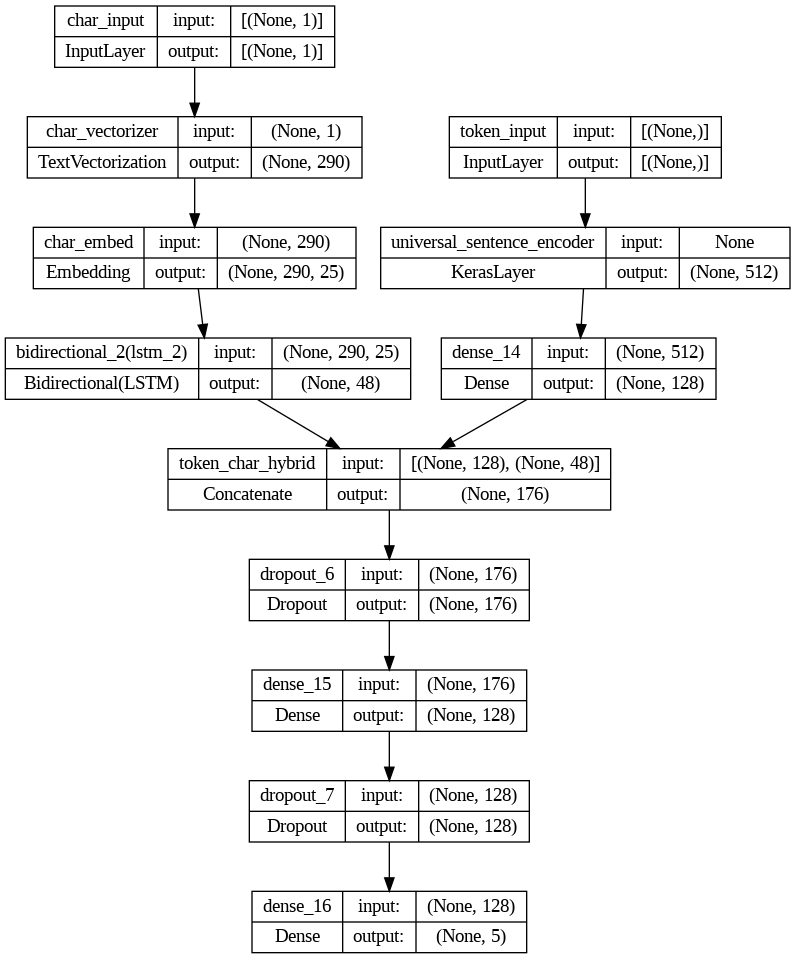

In [139]:
# plot the hybrid model
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

https://medium.com/airbnb-engineering/widetext-a-multimodal-deep-learning-framework-31ce2565880c

You can combine models with different inputs - text, image, etc and concantenate all these inputs into a bigger model.


In [141]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy", optimizer="Adam", metrics="accuracy")

### Combining token and char data into a tf.data.Dataset

In [145]:
# create the Training and Validation datasets to fit and evaluates...

train_hybrid_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_hybrid_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_hybrid_dataset = tf.data.Dataset.zip((train_hybrid_data, train_hybrid_labels))
# prefetch and batch train data
train_hybrid_dataset = train_hybrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

                

In [147]:
# validation data and test data

val_hybrid_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_hybrid_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_hybrid_dataset = tf.data.Dataset.zip((val_hybrid_data, val_hybrid_labels))
# prefetch and batch train data
val_hybrid_dataset = val_hybrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


test_hybrid_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))
test_hybrid_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_hybrid_dataset = tf.data.Dataset.zip((test_hybrid_data, test_hybrid_labels))
# prefetch and batch train data
test_hybrid_dataset = test_hybrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

                

In [148]:
# check out our training char and token embedding dataset
train_hybrid_dataset, val_hybrid_dataset, test_hybrid_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

* Note the order of these two

In [149]:
# fit the model
history_4 = model_4.fit(train_hybrid_dataset,
                        epochs=3,
                        steps_per_epoch = int(0.1*len(train_hybrid_dataset)),
                        validation_data = val_hybrid_dataset, 
                        validation_steps= int(0.1* len(val_hybrid_dataset)))

Epoch 1/5
562/562 [==============================] - 44s 59ms/step - loss: 0.9787 - accuracy: 0.6105 - val_loss: 0.7752 - val_accuracy: 0.6985
Epoch 2/5
562/562 [==============================] - 32s 57ms/step - loss: 0.8039 - accuracy: 0.6888 - val_loss: 0.7139 - val_accuracy: 0.7261
Epoch 3/5
562/562 [==============================] - 35s 62ms/step - loss: 0.7767 - accuracy: 0.7023 - val_loss: 0.7055 - val_accuracy: 0.7337
Epoch 4/5
562/562 [==============================] - 45s 80ms/step - loss: 0.7439 - accuracy: 0.7204 - val_loss: 0.6674 - val_accuracy: 0.7510
Epoch 5/5
562/562 [==============================] - 33s 58ms/step - loss: 0.7540 - accuracy: 0.7139 - val_loss: 0.6505 - val_accuracy: 0.7547


In [ ]:
# Evaluate on the model's performance

In [150]:
model_4.evaluate(val_hybrid_dataset)

945/945 [==============================] - 24s 25ms/step - loss: 0.6578 - accuracy: 0.7497


[0.6577637791633606, 0.7497351765632629]

In [152]:
model_4_preds_probs = model_4.predict(val_hybrid_dataset)
model_4_predictions = tf.argmax(model_4_preds_probs, axis=1)

945/945 [==============================] - 24s 23ms/step


In [154]:
model_2_results, baseline_results

({'accuracy': 71.22335495829472,
  'precision': 0.7127605227235139,
  'recall': 0.7122335495829472,
  'f1': 0.7091098040821843},
 {'accuracy': 72.1832384482987,
  'precision': 0.7186466952323352,
  'recall': 0.7218323844829869,
  'f1': 0.6989250353450294})

In [155]:
model_4_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_4_predictions)


In [156]:
model_4_results

{'accuracy': 74.97352045544817,
 'precision': 0.746758877329345,
 'recall': 0.7497352045544816,
 'f1': 0.7452043213316596}

# Model 5 with pre-trained token embedding + character embeddings + positional embedding

## Feature Engineering
(using label sequence optimizer layer)

- Taking **non-obvious** features from the data and encodding them numerically to help our model learn.

- Data augmentation is a form of feature engineering. If we know that the same image rotated, shifted, etc is still the same image, we're injecting our domain knowledge into the problem to help the model learn.

- Note that engineered features need to be available at test time.

In [158]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


* We want to find a way to encode line_number and total_lines into positional embedding

* Create a dataset for line_number/total_lines vs labels...

In [159]:
test_df.head()

,target,text,line_number,total_lines
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8
1,RESULTS,a post hoc analysis was conducted with the use...,1,8
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8
3,RESULTS,survival analyses were used to assess the asso...,3,8
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8


## Create a positional embeddings

In [163]:
# how many line numbers are there?
train_df["line_number"].value_counts(), train_df["total_lines"].value_counts()

(0     15000
 1     15000
 2     15000
 3     15000
 4     14992
 5     14949
 6     14758
 7     14279
 8     13346
 9     11981
 10    10041
 11     7892
 12     5853
 13     4152
 14     2835
 15     1861
 16     1188
 17      751
 18      462
 19      286
 20      162
 21      101
 22       66
 23       33
 24       22
 25       14
 26        7
 27        4
 28        3
 29        1
 30        1
 Name: line_number, dtype: int64, 11    24468
 10    23639
 12    22113
 9     19400
 13    18438
 14    14610
 8     12285
 15    10768
 7      7464
 16     7429
 17     5202
 6      3353
 18     3344
 19     2480
 20     1281
 5      1146
 21      770
 22      759
 23      264
 4       215
 24      200
 25      182
 26       81
 28       58
 3        32
 30       31
 27       28
 Name: total_lines, dtype: int64)

<AxesSubplot:ylabel='Frequency'>

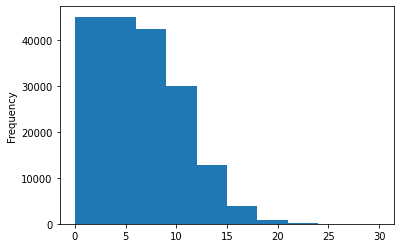

In [164]:
train_df.line_number.plot.hist()

In [167]:
# Use Tensorflow to create one-hot encoded tensors of our "line number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))